# Importing

In [1]:
import pandas as pd
import numpy as np

In [2]:
from pandas.tseries.holiday import USFederalHolidayCalendar, Holiday
from pandas import Timestamp

In [3]:
from workalendar.usa import UnitedStates

In [4]:
from tqdm import tqdm

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [6]:
import cpi

In [7]:
from geopy.distance import geodesic

In [8]:
tqdm.pandas()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from catboost import CatBoostRegressor

In [11]:
from sklearn.cluster import KMeans

# Data preprocessing

In [12]:
data = pd.read_csv(r'data/train.csv')
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [30]:
df = data.copy().sample(5000000)

In [31]:
df = df[
    (df['pickup_longitude'] < -70) & (df['pickup_longitude'] > -75) & 
    (df['pickup_latitude'] < 42) & (df['pickup_latitude'] > 40) &
    (df['dropoff_longitude'] < -70) & (df['dropoff_longitude'] > -75) & 
    (df['dropoff_latitude'] < 42) & (df['dropoff_latitude'] > 40)
     ]

In [32]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
53696488,2012-05-18 10:29:47.0000002,18.5,2012-05-18 10:29:47 UTC,-73.955997,40.780524,-73.988342,40.747763,1
33240891,2012-02-01 13:19:00.00000097,5.7,2012-02-01 13:19:00 UTC,-74.008312,40.729637,-73.999905,40.720375,1
29919177,2015-03-31 15:51:38.0000003,25.5,2015-03-31 15:51:38 UTC,-74.001648,40.724861,-73.967010,40.767002,2
36896031,2012-12-20 14:58:44.0000003,6.0,2012-12-20 14:58:44 UTC,-73.978746,40.756490,-73.987464,40.754142,1
18992869,2011-03-14 17:59:00.000000228,9.7,2011-03-14 17:59:00 UTC,-73.993093,40.736798,-73.977708,40.763755,2


## date preprocessing

In [33]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2009-01-01', end='2016-01-01')
holidays = list(holidays.date)

years = range(2009, 2016)
weekends = []

for year in years:
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year}-12-31')
    all_dates = pd.date_range(start=start_date, end=end_date)

    weekends.extend([date.date() for date in all_dates if date.weekday() >= 5])

In [ ]:
central_park = (40.46, -73.58)

In [35]:
years = [i for i in range(2009, 2016)]
inflation = dict.fromkeys(years, 0)

for key in inflation.keys():
    inflation[key] = round(cpi.inflate(1000, key, to=2009) / 1000, 3)

In [36]:
coords = df[['pickup_latitude', 'pickup_longitude']]
kmeans_pick = KMeans(n_clusters=10, random_state=0).fit(coords)

In [37]:
coords = df[['dropoff_latitude', 'dropoff_longitude']]
kmeans_drop = KMeans(n_clusters=10, random_state=0).fit(coords)

In [ ]:
def preprocess(df, is_train=True):
    df = df.dropna()

    if is_train:
        IQR = df['fare_amount'].quantile(0.75) - df['fare_amount'].quantile(0.25)
        upper_bound = df['fare_amount'].quantile(0.75) + 3 * IQR
        df = df[(df['fare_amount'] >= 0) & (df['fare_amount'] <= upper_bound)]

        
        df = df[(df['passenger_count'] >= 0) & (df['passenger_count'] <= 6)]

    df['distance'] = df.progress_apply(lambda x: geodesic((x['pickup_latitude'], 
                                                       x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).km, axis=1)
    df['pick_up_distance_from_center'] = df.progress_apply(lambda x: geodesic((x['pickup_latitude'], 
                                                       x['pickup_longitude']), (central_park)).km, axis=1)
    # df['drop_off_distance_from_center'] = df.progress_apply(lambda x: geodesic((x['dropoff_latitude'], 
    #                                                    x['dropoff_longitude']), (central_park)).km, axis=1)

    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

    df['is_weekend'] = df['pickup_datetime'].progress_apply(lambda x: x.date() in weekends)
    df['is_holiday'] = df['pickup_datetime'].progress_apply(lambda x: True if x.date() in holidays else False)

    df['year'] = df['pickup_datetime'].progress_apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].progress_apply(lambda x: x.month)
    df['hour'] = df['pickup_datetime'].progress_apply(lambda x: np.sin(2 * np.pi * x.hour / 24))
    df['is_rush_hour'] = df['pickup_datetime'].dt.hour.between(8, 9) | df['pickup_datetime'].dt.hour.between(16, 19)
    df['pickup_cluster'] = kmeans_pick.predict(df[['pickup_latitude', 'pickup_longitude']])
    df['dropoff_cluster'] = kmeans_drop.predict(df[['dropoff_latitude', 'dropoff_longitude']])

    if is_train:
        df['fare_amount_adjusted'] = df.progress_apply(lambda x: inflation[x['pickup_datetime'].year] * x['fare_amount'], axis=1)
    return df

In [39]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
53696488,2012-05-18 10:29:47.0000002,18.5,2012-05-18 10:29:47 UTC,-73.955997,40.780524,-73.988342,40.747763,1
33240891,2012-02-01 13:19:00.00000097,5.7,2012-02-01 13:19:00 UTC,-74.008312,40.729637,-73.999905,40.720375,1
29919177,2015-03-31 15:51:38.0000003,25.5,2015-03-31 15:51:38 UTC,-74.001648,40.724861,-73.967010,40.767002,2
36896031,2012-12-20 14:58:44.0000003,6.0,2012-12-20 14:58:44 UTC,-73.978746,40.756490,-73.987464,40.754142,1
18992869,2011-03-14 17:59:00.000000228,9.7,2011-03-14 17:59:00 UTC,-73.993093,40.736798,-73.977708,40.763755,2


In [40]:
df = preprocess(df)

100%|██████████| 4679614/4679614 [00:29<00:00, 158323.62it/s]


In [41]:
df.to_csv('df.csv')

In [42]:
df.isnull().sum()

key                             0
fare_amount                     0
pickup_datetime                 0
pickup_longitude                0
pickup_latitude                 0
dropoff_longitude               0
dropoff_latitude                0
passenger_count                 0
distance                        0
pick_up_distance_from_center    0
is_weekend                      0
is_holiday                      0
year                            0
month                           0
hour                            0
is_rush_hour                    0
pickup_cluster                  0
dropoff_cluster                 0
fare_amount_adjusted            0
dtype: int64

# графики

<Figure size 1000x1000 with 0 Axes>

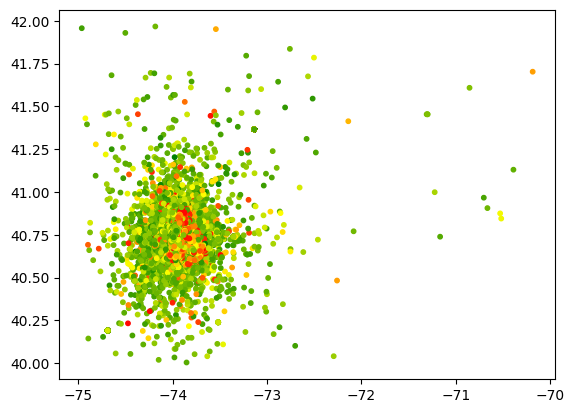

In [43]:
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 10))


quantiles = np.percentile(df['fare_amount'], [0, 25, 50, 75, 100])

# Нормализация с использованием квантилей
norm = Normalize(vmin=quantiles[0], vmax=quantiles[-1])

# Цветовая карта
cmap = plt.get_cmap('RdYlGn')


cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['fare_amount'],
                    s=10, cmap=cmap, norm=norm)

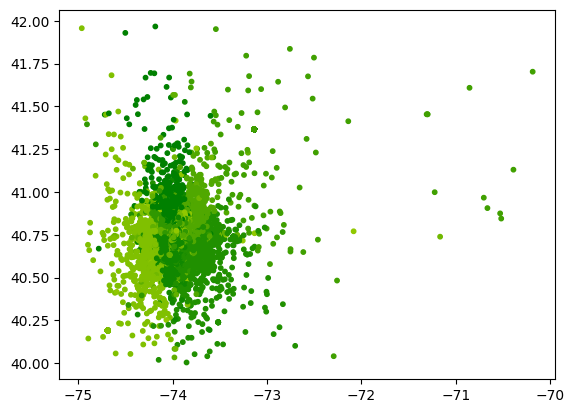

In [44]:
cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['pickup_cluster'],
                    s=10, cmap=cmap, norm=norm)

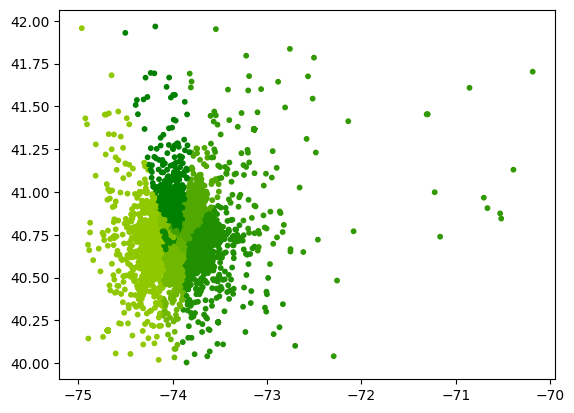

In [45]:
cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['dropoff_cluster'],
                    s=10, cmap=cmap, norm=norm)

<Axes: >

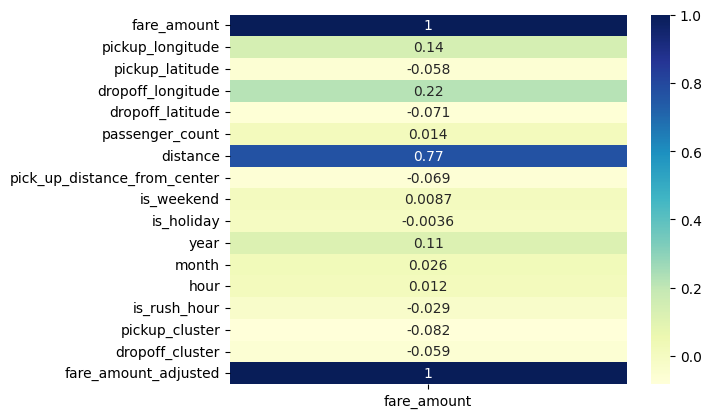

In [46]:
sns.heatmap(df.corr(numeric_only=True)[['fare_amount']], cmap="YlGnBu", annot=True)

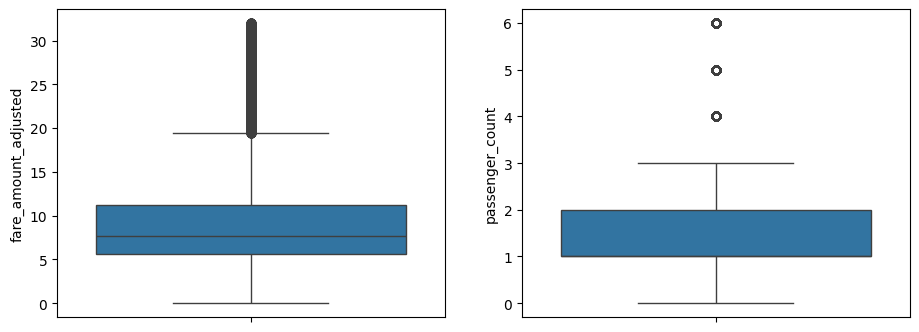

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))


sns.boxplot(df['fare_amount_adjusted'], ax=axes[0])
sns.boxplot(df['passenger_count'], ax=axes[1])
plt.show()

# fitting

In [48]:
X = df.drop(['key', 'fare_amount', 'dropoff_latitude', 'pickup_latitude', 'pickup_longitude', 'pickup_datetime', 'month', 'fare_amount_adjusted'], axis=1)
y = df['fare_amount_adjusted']

In [49]:
X

,dropoff_longitude,passenger_count,distance,pick_up_distance_from_center,is_weekend,is_holiday,year,hour,is_rush_hour,pickup_cluster,dropoff_cluster
53696488,-73.988342,1,4.549089,13.342809,False,False,2012,0.500000,False,9,8
33240891,-73.999905,1,1.249937,19.246055,False,False,2012,-0.258819,False,1,1
29919177,-73.967010,2,5.518841,18.961127,False,False,2015,-0.707107,False,1,4
36896031,-73.987464,1,0.781007,15.843843,False,False,2012,-0.500000,False,7,8
18992869,-73.977708,2,3.263358,17.749258,False,False,2011,-0.965926,True,6,4
...,...,...,...,...,...,...,...,...,...,...,...
9384940,-73.975746,1,2.485638,17.642623,False,False,2009,1.000000,False,6,4
2509650,-73.989380,2,1.957487,18.593659,False,False,2015,-0.965926,True,6,1
24259161,-73.960202,1,0.338229,13.945848,False,False,2011,0.707107,True,9,4
48263643,-73.983700,1,2.862799,19.887561,True,False,2012,-0.258819,False,1,1


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=2024)

model = CatBoostRegressor(depth=4,
                           learning_rate=0.001,
                           iterations=1000,
                           eval_metric='RMSE',
                           random_seed=2024,
                           verbose=50)

In [83]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 5.1366287	test: 5.1275355	best: 5.1275355 (0)	total: 179ms	remaining: 2m 59s
50:	learn: 4.9605174	test: 4.9518170	best: 4.9518170 (50)	total: 6.72s	remaining: 2m 5s
100:	learn: 4.7949972	test: 4.7866839	best: 4.7866839 (100)	total: 13.1s	remaining: 1m 56s
150:	learn: 4.6393311	test: 4.6313641	best: 4.6313641 (150)	total: 19.2s	remaining: 1m 47s
200:	learn: 4.4929945	test: 4.4853684	best: 4.4853684 (200)	total: 25.4s	remaining: 1m 40s
250:	learn: 4.3551521	test: 4.3478250	best: 4.3478250 (250)	total: 31.6s	remaining: 1m 34s
300:	learn: 4.2259033	test: 4.2188312	best: 4.2188312 (300)	total: 38.1s	remaining: 1m 28s
350:	learn: 4.1043630	test: 4.0975474	best: 4.0975474 (350)	total: 44.5s	remaining: 1m 22s
400:	learn: 3.9903959	test: 3.9837678	best: 3.9837678 (400)	total: 51.2s	remaining: 1m 16s
450:	learn: 3.8837416	test: 3.8772602	best: 3.8772602 (450)	total: 58.2s	remaining: 1m 10s
500:	learn: 3.7837599	test: 3.7774028	best: 3.7774028 (500)	total: 1m 5s	remaining: 1m 4s
550:	le

In [84]:
from sklearn.metrics import root_mean_squared_error

In [85]:
len(model.predict(df[X.columns]))

4679614

In [86]:
root_mean_squared_error(np.array(df['fare_amount']), model.predict(df[X.columns]))

3.4461305361079617

# Inferring

In [87]:
pd.read_csv(r'data/sample_submission.csv').head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [88]:
test = pd.read_csv(r'data/test.csv')

In [89]:
test = preprocess(test, is_train=False)

100%|██████████| 9914/9914 [00:00<00:00, 562630.47it/s]


In [90]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pick_up_distance_from_center,is_weekend,is_holiday,year,month,hour,is_rush_hour,pickup_cluster,dropoff_cluster
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2.320991,15.172355,False,False,2015,1,-0.258819,False,7,8
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2.423802,18.141430,False,False,2015,1,-0.258819,False,1,8
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,0.618182,16.331628,True,False,2011,10,0.258819,False,7,8
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,1.959671,15.703942,True,False,2012,12,-0.707107,False,3,8
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,5.382833,14.059455,True,False,2012,12,-0.707107,False,0,8


In [91]:
test[X.columns].head()

,dropoff_longitude,passenger_count,distance,pick_up_distance_from_center,is_weekend,is_holiday,year,hour,is_rush_hour,pickup_cluster,dropoff_cluster
0,-73.981430,1,2.320991,15.172355,False,False,2015,-0.258819,False,7,8
1,-73.998886,1,2.423802,18.141430,False,False,2015,-0.258819,False,1,8
2,-73.979654,1,0.618182,16.331628,True,False,2011,0.258819,False,7,8
3,-73.990448,1,1.959671,15.703942,True,False,2012,-0.707107,False,3,8
4,-73.988565,1,5.382833,14.059455,True,False,2012,-0.707107,False,0,8


In [92]:
test['fare_amount'] = model.predict(test[X.columns])

In [93]:
test['fare_amount'] = test.apply(lambda x: x['fare_amount'] / inflation[x['pickup_datetime'].year], axis=1)

In [94]:
test[['key', 'fare_amount']].to_csv('sub1.csv', index=False)

In [95]:
test[['key', 'fare_amount']]

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.767533
1,2015-01-27 13:08:24.0000003,9.963367
2,2011-10-08 11:53:44.0000002,7.149198
3,2012-12-01 21:12:12.0000002,8.654560
4,2012-12-01 21:12:12.0000003,13.229823
...,...,...
9909,2015-05-10 12:37:51.0000002,9.461250
9910,2015-01-12 17:05:51.0000001,10.785504
9911,2015-04-19 20:44:15.0000001,19.913073
9912,2015-01-31 01:05:19.0000005,18.254933


In [96]:
pd.DataFrame({
    'columns': X.columns,
    'importances': model.feature_importances_}
    )

,columns,importances
0,dropoff_longitude,0.006218
1,passenger_count,0.000000
2,distance,97.232163
3,pick_up_distance_from_center,0.409002
4,is_weekend,0.000000
5,is_holiday,0.000000
6,year,2.352617
7,hour,0.000000
8,is_rush_hour,0.000000
9,pickup_cluster,0.000000


<Figure size 1000x1000 with 0 Axes>

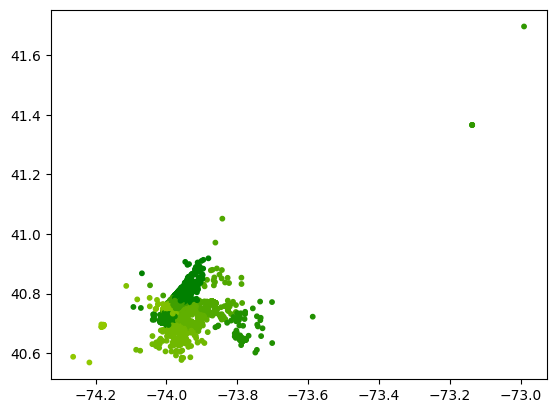

In [100]:
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 10))


# quantiles = np.percentile(test['fare_amount'], [0, 25, 50, 75, 100])

# Нормализация с использованием квантилей
# norm = Normalize(vmin=quantiles[0], vmax=quantiles[-1])

# Цветовая карта
cmap = plt.get_cmap('RdYlGn')


cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(test['dropoff_longitude'], test['dropoff_latitude'], c=test['dropoff_cluster'],
                    s=10, cmap=cmap, norm=norm)

C:\Users\User\AppData\Local\Temp\ipykernel_9968\897063285.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  points = ax.scatter(test['pickup_longitude'], test['pickup_latitude'],


<Figure size 1000x1000 with 0 Axes>

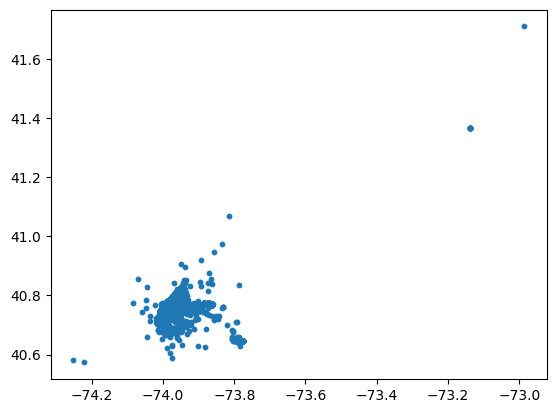

In [98]:
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 10))


# quantiles = np.percentile(test['fare_amount'], [0, 25, 50, 75, 100])

# Нормализация с использованием квантилей
# norm = Normalize(vmin=quantiles[0], vmax=quantiles[-1])

# Цветовая карта
cmap = plt.get_cmap('RdYlGn')


cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(test['pickup_longitude'], test['pickup_latitude'],
                    s=10, cmap=cmap, norm=norm)